In [1]:
import os
import csv
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

from transformers import (
    AutoProcessor, 
    AutoModel,
    get_linear_schedule_with_warmup
)

import albumentations as A
import decord
decord.bridge.set_bridge('torch')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from PIL import Image
import cv2
cv2.setNumThreads(0)  # Disable OpenCV multithreading

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Global processor
PROCESSOR = None

# Set seed for reproducibility
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

d:\Course\Computer Science\CS5983\seethrough\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Checking CUDA availability: ", torch.cuda.is_available())
print("Number of CUDA devices: ", torch.cuda.device_count())
print("CUDA device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
print("PyTorch version: ", torch.__version__)

Checking CUDA availability:  True
Number of CUDA devices:  1
CUDA device name:  NVIDIA GeForce RTX 3060
PyTorch version:  2.7.1+cu118


In [4]:
# Configuration class for training parameters
@dataclass
class Config:
    # Model configuration
    model_name: str = "HuggingFaceTB/SmolVLM-256M-Instruct"  # Using the 256M model
    num_classes: int = 2
    
    # Data configuration  
    data_root: str = "D:/GenVideo"  
    max_frames: int = 4  
    image_size: int = 128
    
    # Training configuration
    batch_size: int = 4  
    learning_rate: float = 1e-5
    weight_decay: float = 1e-4
    num_epochs: int = 10  
    gradient_accumulation_steps: int = 8  
    max_grad_norm: float = 1.0
    warmup_ratio: float = 0.1
    patience_epochs: int = 2
    save_dir: str = "./checkpoints"
    
    # System configuration
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# Create config instance
config = Config()
print(f"Config created with device: {config.device}")
print(f"Data root: {config.data_root}")
print(f"Model: {config.model_name}")

Config created with device: cuda
Data root: D:/GenVideo
Model: HuggingFaceTB/SmolVLM-256M-Instruct


In [5]:
# SmolVLM with custom classification head
class SmolVLMClassifier(nn.Module):
    def __init__(self, model_name: str, num_classes: int = 2):
        super().__init__()
        
        # Load base model
        self.base_model = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float32,
            device_map=None,
            low_cpu_mem_usage=True
        )
        
        self.base_model = self.base_model.float()
        
        # Enable gradient checkpointing
        if hasattr(self.base_model, 'gradient_checkpointing_enable'):
            self.base_model.gradient_checkpointing_enable()
        
        # Get hidden size from model config
        if hasattr(self.base_model.config, 'text_config') and hasattr(self.base_model.config.text_config, 'hidden_size'):
            self.hidden_size = self.base_model.config.text_config.hidden_size
        elif hasattr(self.base_model.config, 'hidden_size'):
            self.hidden_size = self.base_model.config.hidden_size
        else:
            self.hidden_size = 768
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size, num_classes)
        )
        
        # Initialize classifier
        self._init_classifier()
        
    def _init_classifier(self):
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, **inputs):
        # Remove labels from inputs for base model
        labels = inputs.pop('labels', None)
        
        # Get base model outputs
        outputs = self.base_model(**inputs)
        
        # Extract hidden states
        if hasattr(outputs, 'last_hidden_state'):
            hidden_states = outputs.last_hidden_state
        else:
            hidden_states = outputs[0] if hasattr(outputs, '__getitem__') else outputs
        
        # Pool across sequence dimension
        pooled = hidden_states.mean(dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        
        # Calculate loss
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels, label_smoothing=0.1)
        
        # Get probabilities
        probs = F.softmax(logits, dim=-1)
        
        return {
            'loss': loss,
            'logits': logits,
            'probs': probs
        }

In [6]:
# Dataset class for video/image classification
class VideoClassificationDataset(Dataset):
    def __init__(self, csv_file: Path, processor, max_frames: int = 4, 
                 image_size: int = 128, is_train: bool = True):
        self.df = pd.read_csv(csv_file)
        self.processor = processor
        self.max_frames = max_frames
        self.image_size = image_size
        self.is_train = is_train
        
        # Simple resize transform
        self.transform = A.Compose([
            A.Resize(height=image_size, width=image_size)
        ])
    
    def __len__(self):
        return len(self.df)
    
    def _load_video(self, video_path: str) -> np.ndarray:
        try:
            vr = decord.VideoReader(video_path, ctx=decord.cpu(0))
            total_frames = len(vr)
            
            # Sample frames uniformly
            if total_frames <= self.max_frames:
                frame_indices = list(range(total_frames))
                # Pad with last frame if needed
                while len(frame_indices) < self.max_frames:
                    frame_indices.append(total_frames - 1)
            else:
                frame_indices = np.linspace(0, total_frames - 1, self.max_frames, dtype=int)
            
            frames = vr.get_batch(frame_indices).numpy()
            return frames
            
        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            return np.zeros((self.max_frames, self.image_size, self.image_size, 3), dtype=np.uint8)
    
    def _load_image(self, image_path: str) -> np.ndarray:
        try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames = np.array([img])  # Single frame
            return frames
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return np.zeros((1, self.image_size, self.image_size, 3), dtype=np.uint8)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path, label = row['path'], row['label']
        
        # Load frames based on file type
        if file_path.endswith(('.mp4', '.avi', '.mov', '.webm')):
            frames = self._load_video(file_path)
        else:
            frames = self._load_image(file_path)
        
        # Process frames
        processed_frames = []
        for i in range(min(len(frames), self.max_frames)):
            frame = self.transform(image=frames[i])['image']
            processed_frames.append(Image.fromarray(frame))
        
        # Pad with last frame if needed
        while len(processed_frames) < self.max_frames:
            processed_frames.append(processed_frames[-1])
        
        # Prepare prompt with image tokens
        image_tokens = "<image>" * len(processed_frames)
        if len(processed_frames) > 1:
            prompt = f"{image_tokens}Is this video real or AI-generated? Look for temporal inconsistencies, artifacts, and unnatural motion patterns across the frames."
        else:
            prompt = f"{image_tokens}Is this image real or AI-generated? Look for artifacts and inconsistencies."
        
        # Process inputs
        inputs = self.processor(
            text=prompt,
            images=processed_frames,
            return_tensors="pt",
            padding=True,
            truncation=False,
            do_resize=True,
            size={'height': self.image_size, 'width': self.image_size}
        )
        
        # Remove batch dimension
        inputs = {k: v.squeeze(0) if v.dim() > 1 and v.size(0) == 1 else v 
                  for k, v in inputs.items()}
        
        return {
            **inputs,
            'labels': torch.tensor(label, dtype=torch.long)
        }


Training Functions

In [9]:
def prepare_data(config, sample_ratio=0.03):    
    # Load full datasets
    train_df = pd.read_csv(f"{config.data_root}/train.csv")
    val_df = pd.read_csv(f"{config.data_root}/val.csv")
    test_df = pd.read_csv(f"{config.data_root}/test.csv")
    
    # Extract subfolder for stratification
    def extract_subfolder(path):
        parts = path.replace('\\', '/').split('/')
        if len(parts) >= 4:
            class_type = parts[-3]  # real or fake
            subfolder = parts[-2]   # Kinetics, Latte, etc.
            return f"{class_type}_{subfolder}"
        return "unknown"
    
    train_df['subfolder'] = train_df['path'].apply(extract_subfolder)
    val_df['subfolder'] = val_df['path'].apply(extract_subfolder)
    test_df['subfolder'] = test_df['path'].apply(extract_subfolder)
    
    # Filter out rare subfolders
    min_samples = 10
    train_counts = train_df['subfolder'].value_counts()
    valid_subfolders = train_counts[train_counts >= min_samples].index
    
    train_df = train_df[train_df['subfolder'].isin(valid_subfolders)]
    val_df = val_df[val_df['subfolder'].isin(valid_subfolders)]
    
    # Sample with stratification
    train_sample, _ = train_test_split(
        train_df, test_size=1-sample_ratio, 
        stratify=train_df['subfolder'], random_state=SEED
    )
    val_sample, _ = train_test_split(
        val_df, test_size=1-sample_ratio,
        stratify=val_df['subfolder'], random_state=SEED
    )
    
    # For test set, handle potential stratification failures
    try:
        test_valid = test_df[test_df['subfolder'].isin(valid_subfolders)]
        if len(test_valid) > 100:
            test_sample, _ = train_test_split(
                test_valid, test_size=1-sample_ratio,
                stratify=test_valid['subfolder'], random_state=SEED
            )
        else:
            test_sample, _ = train_test_split(
                test_df, test_size=1-sample_ratio, random_state=SEED
            )
    except:
        test_sample, _ = train_test_split(
            test_df, test_size=1-sample_ratio, random_state=SEED
        )
    
    # Save sampled data
    train_sample[['path', 'label']].to_csv('train_sample.csv', index=False)
    val_sample[['path', 'label']].to_csv('val_sample.csv', index=False)
    test_sample[['path', 'label']].to_csv('test_sample.csv', index=False)
    
    print(f"Data prepared:")
    print(f"Train: {len(train_sample)} samples")
    print(f"Val: {len(val_sample)} samples")
    print(f"Test: {len(test_sample)} samples")
    
    return 'train_sample.csv', 'val_sample.csv', 'test_sample.csv'

In [10]:
def evaluate_model(model, data_loader, config, desc="Evaluation"):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=desc):
            try:
                batch = {k: v.to(config.device) if isinstance(v, torch.Tensor) else v 
                        for k, v in batch.items()}
                outputs = model(**batch)
                
                if outputs['loss'] is not None:
                    total_loss += outputs['loss'].item()
                
                preds = outputs['logits'].argmax(dim=-1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['labels'].cpu().numpy())
                all_probs.extend(outputs['probs'].cpu().numpy())
                
            except Exception as e:
                print(f"Error in batch: {e}")
                continue
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    # Calculate AUC for binary classification
    auc = None
    if len(all_probs) > 0:
        probs_array = np.array(all_probs)
        if probs_array.shape[1] == 2:
            auc = roc_auc_score(all_labels, probs_array[:, 1])
    
    avg_loss = total_loss / len(data_loader) if len(data_loader) > 0 else 0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


In [11]:
def train_epoch(model, train_loader, optimizer, scheduler, config, epoch):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(pbar):
        try:
            # Move to device
            batch = {k: v.to(config.device) if isinstance(v, torch.Tensor) else v 
                    for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs['loss'] / config.gradient_accumulation_steps
            
            # Check for invalid loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Invalid loss detected, skipping batch")
                optimizer.zero_grad()
                continue
            
            # Backward pass
            loss.backward()
            
            # Gradient accumulation
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                clip_grad_norm_(model.parameters(), config.max_grad_norm)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            total_loss += loss.item() * config.gradient_accumulation_steps
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss.item() * config.gradient_accumulation_steps:.4f}",
                'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
            })
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            optimizer.zero_grad()
            continue
    
    return total_loss / len(train_loader)

In [12]:
def train_model(config, train_csv, val_csv):    
    # Initialize processor
    global PROCESSOR
    if PROCESSOR is None:
        PROCESSOR = AutoProcessor.from_pretrained(config.model_name, trust_remote_code=True)
    
    # Initialize model
    model = SmolVLMClassifier(config.model_name, config.num_classes)
    model = model.to(config.device)
    
    # Create datasets
    train_dataset = VideoClassificationDataset(train_csv, PROCESSOR, config.max_frames, config.image_size, is_train=True)
    val_dataset = VideoClassificationDataset(val_csv, PROCESSOR, config.max_frames, config.image_size, is_train=False)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Setup optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    warmup_steps = int(config.warmup_ratio * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    
    # Training loop
    best_val_acc = 0
    patience_counter = 0
    train_losses = []
    val_metrics_history = []
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, config, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_metrics = evaluate_model(model, val_loader, config, desc="Validation")
        val_metrics_history.append(val_metrics)
        
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}, "
              f"F1: {val_metrics['f1']:.4f}")
        
        # Save best model
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            patience_counter = 0
            torch.save(model.state_dict(), f"{config.save_dir}/best_model.pth")
            print(f"New best model saved. Val Acc: {val_metrics['accuracy']:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{config.patience_epochs}")
        
        # Early stopping
        if patience_counter >= config.patience_epochs:
            print(f"Early stopping triggered")
            break
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot([m['loss'] for m in val_metrics_history], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot([m['accuracy'] for m in val_metrics_history], 'g-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{config.save_dir}/training_curves.png", dpi=300)
    plt.show()
    
    return model, best_val_acc

Data prepared:
Train: 4996 samples
Val: 624 samples
Test: 624 samples
Off the shelf model performance:


Baseline Test:  18%|█▊        | 28/156 [00:34<02:45,  1.29s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4...


Baseline Test:  56%|█████▋    | 88/156 [01:49<01:25,  1.26s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4: [01:57:55] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4] Failed to measure duration/frame-count due to broken metadata.


Baseline Test:  65%|██████▍   | 101/156 [02:07<01:22,  1.50s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4...


Baseline Test:  67%|██████▋   | 105/156 [02:12<01:05,  1.29s/it]

Error loading video D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4...


Baseline Test: 100%|██████████| 156/156 [03:17<00:00,  1.26s/it]


---
Accuracy:  0.5128
Precision: 0.5188
Recall:    0.5128
F1-Score:  0.4875
AUC:       0.5035
---

---
Finetuning:

Epoch 1/10


Training Epoch 1:   0%|          | 6/1249 [00:21<1:14:05,  3.58s/it, loss=1.5647, lr=0.00e+00]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [01:59:45] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:   6%|▌         | 72/1249 [04:21<1:10:10,  3.58s/it, loss=1.1077, lr=5.77e-07]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 1:   7%|▋         | 92/1249 [05:32<1:09:14,  3.59s/it, loss=0.7988, lr=7.05e-07]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [02:04:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:   9%|▉         | 110/1249 [06:38<1:09:11,  3.64s/it, loss=0.4538, lr=8.33e-07]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 1:   9%|▉         | 112/1249 [06:45<1:08:21,  3.61s/it, loss=0.9297, lr=8.97e-07]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 1:  12%|█▏        | 146/1249 [08:44<1:03:59,  3.48s/it, loss=0.7145, lr=1.15e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 1:  14%|█▍        | 181/1249 [10:51<1:06:22,  3.73s/it, loss=0.5241, lr=1.41e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 1:  15%|█▍        | 187/1249 [11:12<1:03:54,  3.61s/it, loss=0.4867, lr=1.47e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 1:  17%|█▋        | 216/1249 [12:58<1:05:51,  3.83s/it, loss=0.6448, lr=1.73e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 1:  24%|██▎       | 295/1249 [17:43<57:24,  3.61s/it, loss=0.4657, lr=2.31e-06]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 1:  24%|██▍       | 303/1249 [18:12<57:27,  3.64s/it, loss=1.0240, lr=2.37e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 1:  24%|██▍       | 306/1249 [18:23<56:45,  3.61s/it, loss=0.7071, lr=2.44e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [02:17:47] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  27%|██▋       | 342/1249 [20:33<54:15,  3.59s/it, loss=0.2672, lr=2.69e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 1:  28%|██▊       | 345/1249 [20:44<53:50,  3.57s/it, loss=1.0713, lr=2.76e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 1:  32%|███▏      | 398/1249 [23:56<51:38,  3.64s/it, loss=0.3101, lr=3.14e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [02:23:19] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  35%|███▍      | 433/1249 [26:01<48:57,  3.60s/it, loss=0.3115, lr=3.46e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 1:  35%|███▌      | 439/1249 [26:23<48:34,  3.60s/it, loss=0.2422, lr=3.46e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 1:  38%|███▊      | 478/1249 [28:46<46:04,  3.59s/it, loss=0.4192, lr=3.78e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [02:28:10] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  40%|███▉      | 498/1249 [29:58<44:57,  3.59s/it, loss=0.2144, lr=3.97e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 1:  44%|████▍     | 551/1249 [33:10<42:31,  3.66s/it, loss=0.7351, lr=4.36e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 1:  45%|████▌     | 565/1249 [34:01<41:17,  3.62s/it, loss=0.2085, lr=4.49e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 1:  46%|████▌     | 569/1249 [34:15<40:43,  3.59s/it, loss=0.4773, lr=4.55e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...
Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [02:33:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  47%|████▋     | 583/1249 [35:05<39:56,  3.60s/it, loss=0.3763, lr=4.62e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 1:  47%|████▋     | 589/1249 [35:27<39:06,  3.55s/it, loss=0.6143, lr=4.68e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 1:  59%|█████▉    | 736/1249 [45:38<38:53,  4.55s/it, loss=0.2544, lr=5.90e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 1:  59%|█████▉    | 741/1249 [46:00<38:01,  4.49s/it, loss=0.2274, lr=5.90e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 1:  61%|██████    | 757/1249 [47:13<36:59,  4.51s/it, loss=0.3189, lr=6.03e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 1:  63%|██████▎   | 784/1249 [49:15<34:45,  4.49s/it, loss=0.2858, lr=6.28e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 1:  64%|██████▍   | 802/1249 [50:36<33:32,  4.50s/it, loss=0.3980, lr=6.41e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [02:50:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  65%|██████▌   | 813/1249 [51:27<33:09,  4.56s/it, loss=0.6644, lr=6.47e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 1:  66%|██████▌   | 825/1249 [52:21<31:55,  4.52s/it, loss=0.2604, lr=6.60e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 1:  70%|███████   | 877/1249 [56:26<27:59,  4.51s/it, loss=0.2719, lr=6.99e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 1:  71%|███████   | 885/1249 [57:02<27:26,  4.52s/it, loss=0.2406, lr=7.05e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 1:  73%|███████▎  | 911/1249 [58:59<25:27,  4.52s/it, loss=0.3480, lr=7.24e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 1:  74%|███████▍  | 924/1249 [59:59<24:49,  4.58s/it, loss=0.2845, lr=7.37e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 1:  80%|███████▉  | 994/1249 [1:05:26<19:16,  4.54s/it, loss=0.2474, lr=7.95e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 1:  84%|████████▍ | 1049/1249 [1:09:36<14:59,  4.50s/it, loss=0.7185, lr=8.40e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 1:  85%|████████▌ | 1064/1249 [1:10:44<13:54,  4.51s/it, loss=0.2302, lr=8.53e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 1:  87%|████████▋ | 1090/1249 [1:12:41<12:03,  4.55s/it, loss=0.2138, lr=8.72e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [03:12:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  88%|████████▊ | 1098/1249 [1:13:18<11:19,  4.50s/it, loss=0.3377, lr=8.78e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 1:  92%|█████████▏| 1145/1249 [1:16:54<07:58,  4.60s/it, loss=0.2094, lr=9.17e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [03:16:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  93%|█████████▎| 1162/1249 [1:18:11<06:33,  4.52s/it, loss=0.2384, lr=9.29e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [03:17:35] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 1:  94%|█████████▍| 1173/1249 [1:19:01<05:40,  4.48s/it, loss=1.2095, lr=9.36e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 1:  96%|█████████▌| 1198/1249 [1:20:54<03:50,  4.53s/it, loss=0.2699, lr=9.55e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Validation:   3%|▎         | 5/156 [00:08<04:28,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:01<03:43,  1.83s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [03:25:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:38<03:04,  1.81s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [01:58<02:44,  1.80s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [03:26:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:34<02:10,  1.84s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:14<00:28,  1.80s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:19<00:23,  1.82s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:43<00:00,  1.82s/it]


Train Loss: 0.4677
Val Loss: 0.3640, Acc: 0.8942, F1: 0.8934
New best model saved. Val Acc: 0.8942

Epoch 2/10


Training Epoch 2:   1%|          | 13/1249 [00:58<1:34:11,  4.57s/it, loss=0.4441, lr=9.99e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 2:   2%|▏         | 28/1249 [02:07<1:33:29,  4.59s/it, loss=0.2224, lr=9.98e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 2:   5%|▌         | 64/1249 [04:51<1:29:45,  4.54s/it, loss=0.2356, lr=9.94e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 2:   6%|▌         | 78/1249 [05:54<1:28:05,  4.51s/it, loss=0.3134, lr=9.94e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 2:   7%|▋         | 89/1249 [06:44<1:27:54,  4.55s/it, loss=0.2329, lr=9.92e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 2:  10%|█         | 126/1249 [09:32<1:25:07,  4.55s/it, loss=0.5088, lr=9.89e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [03:38:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  11%|█         | 136/1249 [10:18<1:25:08,  4.59s/it, loss=0.2121, lr=9.88e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 2:  12%|█▏        | 155/1249 [11:44<1:22:34,  4.53s/it, loss=0.2212, lr=9.86e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [03:40:43] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  21%|██        | 265/1249 [20:03<1:14:45,  4.56s/it, loss=0.2411, lr=9.77e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 2:  23%|██▎       | 291/1249 [22:01<1:12:51,  4.56s/it, loss=0.2846, lr=9.74e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 2:  26%|██▌       | 326/1249 [24:40<1:09:35,  4.52s/it, loss=0.2106, lr=9.72e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 2:  28%|██▊       | 348/1249 [26:19<1:08:07,  4.54s/it, loss=0.2450, lr=9.69e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 2:  30%|██▉       | 373/1249 [28:12<1:05:51,  4.51s/it, loss=0.2131, lr=9.67e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 2:  32%|███▏      | 400/1249 [30:15<1:04:36,  4.57s/it, loss=0.3046, lr=9.64e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 2:  33%|███▎      | 416/1249 [31:27<1:03:26,  4.57s/it, loss=0.2335, lr=9.63e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [04:00:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  34%|███▍      | 422/1249 [31:54<1:02:27,  4.53s/it, loss=0.2488, lr=9.63e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [04:00:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  35%|███▌      | 438/1249 [33:07<1:00:47,  4.50s/it, loss=0.2157, lr=9.62e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [04:02:06] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  36%|███▌      | 451/1249 [34:07<1:01:23,  4.62s/it, loss=0.2223, lr=9.60e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 2:  37%|███▋      | 458/1249 [34:39<59:29,  4.51s/it, loss=0.2235, lr=9.59e-06]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 2:  39%|███▉      | 486/1249 [36:46<57:44,  4.54s/it, loss=0.2730, lr=9.57e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 2:  39%|███▉      | 490/1249 [37:04<57:22,  4.54s/it, loss=0.4439, lr=9.57e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 2:  42%|████▏     | 524/1249 [39:39<54:54,  4.54s/it, loss=0.2145, lr=9.54e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 2:  45%|████▍     | 557/1249 [42:09<51:58,  4.51s/it, loss=0.2313, lr=9.51e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 2:  56%|█████▌    | 696/1249 [52:48<41:47,  4.53s/it, loss=0.2107, lr=9.38e-06]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 2:  56%|█████▌    | 701/1249 [53:11<41:45,  4.57s/it, loss=0.5208, lr=9.38e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 2:  56%|█████▌    | 702/1249 [53:16<41:51,  4.59s/it, loss=0.7669, lr=9.38e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 2:  59%|█████▉    | 740/1249 [56:08<38:18,  4.52s/it, loss=0.2443, lr=9.35e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 2:  60%|██████    | 754/1249 [57:12<37:47,  4.58s/it, loss=0.2454, lr=9.33e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 2:  63%|██████▎   | 789/1249 [59:51<35:06,  4.58s/it, loss=0.2888, lr=9.30e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 2:  64%|██████▎   | 794/1249 [1:00:14<34:48,  4.59s/it, loss=0.2109, lr=9.30e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [04:29:14] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  65%|██████▍   | 806/1249 [1:01:09<33:30,  4.54s/it, loss=0.2039, lr=9.29e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 2:  67%|██████▋   | 835/1249 [1:03:21<31:14,  4.53s/it, loss=0.2058, lr=9.26e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 2:  70%|███████   | 879/1249 [1:06:41<28:39,  4.65s/it, loss=0.2084, lr=9.22e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 2:  72%|███████▏  | 899/1249 [1:08:11<26:25,  4.53s/it, loss=0.2527, lr=9.20e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 2:  84%|████████▍ | 1049/1249 [1:19:33<15:02,  4.51s/it, loss=0.2101, lr=9.07e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 2:  87%|████████▋ | 1088/1249 [1:22:31<12:08,  4.53s/it, loss=0.4707, lr=9.03e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 2:  89%|████████▉ | 1114/1249 [1:24:31<10:15,  4.56s/it, loss=0.2043, lr=9.01e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 2:  92%|█████████▏| 1148/1249 [1:27:05<07:40,  4.56s/it, loss=0.2640, lr=8.98e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [04:56:04] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  92%|█████████▏| 1150/1249 [1:27:14<07:31,  4.56s/it, loss=0.2027, lr=8.98e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 2:  95%|█████████▍| 1183/1249 [1:29:44<05:00,  4.55s/it, loss=0.2219, lr=8.95e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [04:58:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  96%|█████████▋| 1204/1249 [1:31:20<03:22,  4.49s/it, loss=0.2105, lr=8.93e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 2:  97%|█████████▋| 1208/1249 [1:31:38<03:07,  4.57s/it, loss=0.8182, lr=8.93e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [05:00:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 2:  97%|█████████▋| 1209/1249 [1:31:42<03:02,  4.56s/it, loss=0.2207, lr=8.93e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 2:  97%|█████████▋| 1212/1249 [1:31:56<02:49,  4.58s/it, loss=0.4711, lr=8.93e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 2:  99%|█████████▊| 1232/1249 [1:33:27<01:17,  4.57s/it, loss=0.2114, lr=8.90e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [05:02:26] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:   3%|▎         | 5/156 [00:08<04:28,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:01<03:44,  1.84s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [05:04:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:39<03:04,  1.81s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [01:59<02:45,  1.82s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [05:05:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:35<02:12,  1.86s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:16<00:29,  1.83s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:21<00:23,  1.83s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:45<00:00,  1.83s/it]


Train Loss: 0.2823
Val Loss: 0.2704, Acc: 0.9567, F1: 0.9567
New best model saved. Val Acc: 0.9567

Epoch 3/10


Training Epoch 3:   3%|▎         | 39/1249 [02:57<1:31:52,  4.56s/it, loss=0.2058, lr=8.86e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 3:   6%|▌         | 73/1249 [05:32<1:29:22,  4.56s/it, loss=0.2063, lr=8.83e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 3:   6%|▌         | 76/1249 [05:46<1:29:28,  4.58s/it, loss=0.2038, lr=8.83e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 3:   7%|▋         | 85/1249 [06:27<1:28:26,  4.56s/it, loss=0.2420, lr=8.82e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 3:   8%|▊         | 100/1249 [07:36<1:27:06,  4.55s/it, loss=0.2101, lr=8.80e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [05:16:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  14%|█▍        | 173/1249 [13:08<1:20:50,  4.51s/it, loss=0.2199, lr=8.74e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 3:  15%|█▍        | 186/1249 [14:07<1:20:32,  4.55s/it, loss=0.2231, lr=8.73e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 3:  22%|██▏       | 274/1249 [20:48<1:13:39,  4.53s/it, loss=0.2264, lr=8.65e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [05:29:23] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  24%|██▎       | 295/1249 [22:23<1:12:03,  4.53s/it, loss=0.2113, lr=8.63e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 3:  24%|██▍       | 305/1249 [23:09<1:12:15,  4.59s/it, loss=0.2151, lr=8.62e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 3:  27%|██▋       | 332/1249 [25:11<1:09:09,  4.53s/it, loss=0.2015, lr=8.60e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [05:33:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  27%|██▋       | 338/1249 [25:38<1:09:40,  4.59s/it, loss=0.2154, lr=8.59e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 3:  31%|███       | 382/1249 [28:59<1:05:59,  4.57s/it, loss=0.2180, lr=8.56e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [05:37:34] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  38%|███▊      | 470/1249 [35:39<57:43,  4.45s/it, loss=0.2089, lr=8.48e-06]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [05:44:14] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  39%|███▉      | 489/1249 [37:06<57:56,  4.57s/it, loss=0.2052, lr=8.46e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 3:  41%|████▏     | 517/1249 [39:13<55:26,  4.54s/it, loss=0.5245, lr=8.43e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 3:  41%|████▏     | 518/1249 [39:18<55:20,  4.54s/it, loss=0.2086, lr=8.43e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [05:47:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  45%|████▍     | 560/1249 [42:29<52:13,  4.55s/it, loss=0.2009, lr=8.39e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 3:  49%|████▊     | 607/1249 [46:02<48:15,  4.51s/it, loss=0.2037, lr=8.36e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 3:  50%|████▉     | 623/1249 [47:15<47:34,  4.56s/it, loss=0.2044, lr=8.34e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 3:  50%|█████     | 630/1249 [47:47<46:40,  4.52s/it, loss=0.2052, lr=8.33e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [05:56:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  55%|█████▌    | 691/1249 [52:24<42:09,  4.53s/it, loss=0.6480, lr=8.28e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 3:  56%|█████▌    | 697/1249 [52:51<41:35,  4.52s/it, loss=0.2051, lr=8.27e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 3:  56%|█████▌    | 702/1249 [53:14<41:52,  4.59s/it, loss=0.2171, lr=8.27e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 3:  59%|█████▉    | 737/1249 [55:54<38:56,  4.56s/it, loss=0.2072, lr=8.23e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 3:  61%|██████▏   | 767/1249 [58:10<36:39,  4.56s/it, loss=0.2286, lr=8.21e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 3:  65%|██████▍   | 808/1249 [1:01:18<33:37,  4.58s/it, loss=0.2022, lr=8.17e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...
Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 3:  68%|██████▊   | 846/1249 [1:04:11<30:30,  4.54s/it, loss=0.2010, lr=8.14e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 3:  73%|███████▎  | 911/1249 [1:09:08<25:52,  4.59s/it, loss=0.2056, lr=8.09e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [06:17:44] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  80%|███████▉  | 995/1249 [1:15:29<18:59,  4.49s/it, loss=0.2021, lr=8.01e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 3:  80%|███████▉  | 997/1249 [1:15:39<19:06,  4.55s/it, loss=0.1992, lr=8.01e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 3:  80%|████████  | 1005/1249 [1:16:15<18:24,  4.53s/it, loss=0.2056, lr=8.00e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 3:  81%|████████▏ | 1015/1249 [1:17:01<17:46,  4.56s/it, loss=0.2036, lr=7.99e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 3:  82%|████████▏ | 1020/1249 [1:17:23<17:15,  4.52s/it, loss=0.2053, lr=7.99e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 3:  85%|████████▌ | 1064/1249 [1:20:43<14:02,  4.55s/it, loss=0.2132, lr=7.94e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 3:  86%|████████▌ | 1076/1249 [1:21:38<13:14,  4.59s/it, loss=0.2048, lr=7.94e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 3:  91%|█████████ | 1131/1249 [1:25:49<09:02,  4.60s/it, loss=0.4982, lr=7.89e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 3:  93%|█████████▎| 1156/1249 [1:27:42<07:02,  4.55s/it, loss=0.2174, lr=7.86e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 3:  93%|█████████▎| 1164/1249 [1:28:18<06:24,  4.53s/it, loss=0.2064, lr=7.86e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 3:  93%|█████████▎| 1167/1249 [1:28:32<06:06,  4.47s/it, loss=0.2187, lr=7.86e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 3:  94%|█████████▍| 1176/1249 [1:29:13<05:31,  4.53s/it, loss=0.2822, lr=7.84e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [06:37:48] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  95%|█████████▍| 1183/1249 [1:29:45<05:00,  4.55s/it, loss=0.2165, lr=7.84e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [06:38:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 3:  97%|█████████▋| 1209/1249 [1:31:42<03:02,  4.55s/it, loss=0.2096, lr=7.81e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Validation:   3%|▎         | 5/156 [00:09<04:29,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:01<03:45,  1.85s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [06:44:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:39<03:04,  1.81s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [02:00<02:51,  1.88s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [06:45:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:36<02:11,  1.85s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:17<00:29,  1.82s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:22<00:23,  1.83s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:46<00:00,  1.84s/it]


Train Loss: 0.2388
Val Loss: 0.2427, Acc: 0.9728, F1: 0.9728
New best model saved. Val Acc: 0.9728

Epoch 4/10


Training Epoch 4:   3%|▎         | 33/1249 [02:30<1:31:09,  4.50s/it, loss=0.2015, lr=7.75e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 4:   5%|▍         | 58/1249 [04:23<1:30:27,  4.56s/it, loss=0.2035, lr=7.73e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 4:   7%|▋         | 86/1249 [06:30<1:28:03,  4.54s/it, loss=0.2040, lr=7.71e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 4:   8%|▊         | 99/1249 [07:29<1:26:50,  4.53s/it, loss=0.2025, lr=7.69e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 4:  10%|▉         | 122/1249 [09:14<1:25:24,  4.55s/it, loss=0.2066, lr=7.67e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 4:  10%|█         | 130/1249 [09:50<1:25:01,  4.56s/it, loss=0.2014, lr=7.67e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [06:58:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  11%|█         | 133/1249 [10:05<1:26:21,  4.64s/it, loss=0.2255, lr=7.67e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [06:58:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  12%|█▏        | 153/1249 [11:35<1:22:58,  4.54s/it, loss=0.2052, lr=7.64e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 4:  12%|█▏        | 156/1249 [11:49<1:22:23,  4.52s/it, loss=0.2082, lr=7.64e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 4:  14%|█▍        | 175/1249 [13:16<1:21:30,  4.55s/it, loss=0.1998, lr=7.63e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 4:  14%|█▍        | 176/1249 [13:20<1:20:58,  4.53s/it, loss=0.2078, lr=7.62e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 4:  18%|█▊        | 228/1249 [17:17<1:16:41,  4.51s/it, loss=0.2032, lr=7.58e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 4:  21%|██▏       | 267/1249 [20:14<1:13:49,  4.51s/it, loss=0.2023, lr=7.54e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 4:  29%|██▉       | 360/1249 [27:18<1:07:21,  4.55s/it, loss=0.2018, lr=7.46e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 4:  30%|███       | 376/1249 [28:30<1:06:51,  4.60s/it, loss=0.2026, lr=7.44e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 4:  31%|███       | 390/1249 [29:34<1:04:51,  4.53s/it, loss=0.1987, lr=7.44e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [07:17:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  32%|███▏      | 397/1249 [30:06<1:04:23,  4.53s/it, loss=0.1998, lr=7.43e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 4:  35%|███▍      | 437/1249 [33:08<1:01:47,  4.57s/it, loss=0.2004, lr=7.40e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 4:  37%|███▋      | 456/1249 [34:35<1:00:56,  4.61s/it, loss=0.2084, lr=7.37e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 4:  37%|███▋      | 468/1249 [35:30<59:29,  4.57s/it, loss=0.2089, lr=7.37e-06]  

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 4:  38%|███▊      | 478/1249 [36:15<58:23,  4.54s/it, loss=0.2039, lr=7.36e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [07:24:27] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  40%|███▉      | 495/1249 [37:32<57:17,  4.56s/it, loss=0.2175, lr=7.35e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 4:  43%|████▎     | 538/1249 [40:47<54:19,  4.58s/it, loss=0.2063, lr=7.30e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [07:28:59] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  47%|████▋     | 581/1249 [44:03<50:18,  4.52s/it, loss=0.2077, lr=7.27e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 4:  48%|████▊     | 599/1249 [45:25<49:00,  4.52s/it, loss=0.2107, lr=7.25e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 4:  59%|█████▉    | 743/1249 [56:21<38:27,  4.56s/it, loss=0.1997, lr=7.12e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 4:  60%|██████    | 755/1249 [57:15<37:31,  4.56s/it, loss=0.2016, lr=7.11e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 4:  62%|██████▏   | 777/1249 [58:56<35:58,  4.57s/it, loss=0.2035, lr=7.09e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 4:  63%|██████▎   | 786/1249 [59:37<35:15,  4.57s/it, loss=0.2027, lr=7.08e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 4:  63%|██████▎   | 788/1249 [59:46<34:39,  4.51s/it, loss=0.2045, lr=7.08e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 4:  65%|██████▌   | 813/1249 [1:01:40<32:50,  4.52s/it, loss=0.2019, lr=7.06e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [07:49:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  66%|██████▌   | 820/1249 [1:02:11<32:18,  4.52s/it, loss=0.2098, lr=7.05e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [07:50:23] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  67%|██████▋   | 837/1249 [1:03:30<31:27,  4.58s/it, loss=0.2055, lr=7.04e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 4:  67%|██████▋   | 843/1249 [1:03:57<30:35,  4.52s/it, loss=0.2030, lr=7.03e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 4:  70%|███████   | 876/1249 [1:06:27<28:13,  4.54s/it, loss=0.1997, lr=7.00e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [07:54:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  70%|███████   | 880/1249 [1:06:45<27:59,  4.55s/it, loss=0.2012, lr=7.00e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [07:54:57] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  73%|███████▎  | 914/1249 [1:09:20<25:28,  4.56s/it, loss=0.2021, lr=6.97e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 4:  73%|███████▎  | 917/1249 [1:09:34<25:13,  4.56s/it, loss=0.2049, lr=6.97e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [07:57:46] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 4:  74%|███████▍  | 929/1249 [1:10:28<24:13,  4.54s/it, loss=0.2849, lr=6.95e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 4:  75%|███████▍  | 933/1249 [1:10:46<23:58,  4.55s/it, loss=0.2140, lr=6.95e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 4:  81%|████████▏ | 1016/1249 [1:17:03<17:35,  4.53s/it, loss=0.2064, lr=6.88e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 4:  85%|████████▍ | 1060/1249 [1:20:24<14:26,  4.59s/it, loss=0.2000, lr=6.84e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 4:  87%|████████▋ | 1084/1249 [1:22:14<12:33,  4.57s/it, loss=0.2013, lr=6.82e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 4:  88%|████████▊ | 1098/1249 [1:23:18<11:23,  4.53s/it, loss=0.9851, lr=6.80e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 4:  94%|█████████▍| 1179/1249 [1:29:26<05:17,  4.53s/it, loss=0.2139, lr=6.73e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Validation:   3%|▎         | 5/156 [00:09<04:29,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:02<03:46,  1.86s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [08:23:58] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:40<03:09,  1.86s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [02:00<02:48,  1.85s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [08:24:57] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:37<02:10,  1.84s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:17<00:29,  1.81s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:23<00:23,  1.82s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:47<00:00,  1.84s/it]


Train Loss: 0.2237
Val Loss: 0.2451, Acc: 0.9824, F1: 0.9824
New best model saved. Val Acc: 0.9824

Epoch 5/10


Training Epoch 5:   1%|          | 8/1249 [00:36<1:34:00,  4.55s/it, loss=0.2041, lr=6.66e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [08:28:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:   4%|▎         | 44/1249 [03:21<1:32:09,  4.59s/it, loss=0.2073, lr=6.63e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 5:   4%|▍         | 54/1249 [04:06<1:30:41,  4.55s/it, loss=0.2001, lr=6.63e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 5:  10%|▉         | 120/1249 [09:06<1:26:33,  4.60s/it, loss=0.2065, lr=6.56e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [08:36:54] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  11%|█         | 136/1249 [10:19<1:24:41,  4.57s/it, loss=0.2025, lr=6.55e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 5:  14%|█▍        | 180/1249 [13:39<1:21:16,  4.56s/it, loss=0.2040, lr=6.51e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 5:  23%|██▎       | 288/1249 [21:50<1:12:59,  4.56s/it, loss=0.2019, lr=6.41e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 5:  23%|██▎       | 290/1249 [21:59<1:12:15,  4.52s/it, loss=0.2010, lr=6.41e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 5:  25%|██▌       | 316/1249 [23:57<1:10:38,  4.54s/it, loss=0.2618, lr=6.39e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 5:  29%|██▉       | 364/1249 [27:35<1:07:26,  4.57s/it, loss=0.2009, lr=6.35e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 5:  30%|██▉       | 370/1249 [28:02<1:05:55,  4.50s/it, loss=0.2035, lr=6.34e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [08:55:50] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  30%|███       | 375/1249 [28:25<1:06:40,  4.58s/it, loss=0.1996, lr=6.34e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 5:  30%|███       | 376/1249 [28:30<1:06:46,  4.59s/it, loss=0.3470, lr=6.33e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 5:  33%|███▎      | 413/1249 [31:17<1:03:22,  4.55s/it, loss=0.2026, lr=6.31e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 5:  35%|███▍      | 437/1249 [33:07<1:01:26,  4.54s/it, loss=0.2006, lr=6.28e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 5:  37%|███▋      | 465/1249 [35:15<59:35,  4.56s/it, loss=0.2039, lr=6.26e-06]  

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 5:  44%|████▍     | 555/1249 [42:05<53:12,  4.60s/it, loss=0.2086, lr=6.18e-06]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [09:09:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  45%|████▌     | 565/1249 [42:51<51:37,  4.53s/it, loss=0.2059, lr=6.17e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 5:  46%|████▌     | 571/1249 [43:18<50:59,  4.51s/it, loss=0.2022, lr=6.16e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 5:  48%|████▊     | 603/1249 [45:45<49:20,  4.58s/it, loss=0.2032, lr=6.14e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 5:  51%|█████▏    | 643/1249 [48:46<46:03,  4.56s/it, loss=0.2010, lr=6.10e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 5:  52%|█████▏    | 647/1249 [49:04<45:31,  4.54s/it, loss=0.2032, lr=6.10e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 5:  56%|█████▋    | 705/1249 [53:28<41:12,  4.55s/it, loss=0.2035, lr=6.04e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 5:  59%|█████▊    | 733/1249 [55:35<38:56,  4.53s/it, loss=0.2031, lr=6.02e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 5:  60%|█████▉    | 749/1249 [56:48<37:43,  4.53s/it, loss=0.6647, lr=6.01e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...
Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [09:24:36] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  63%|██████▎   | 788/1249 [59:46<35:21,  4.60s/it, loss=0.1987, lr=5.97e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...
Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 5:  65%|██████▍   | 807/1249 [1:01:12<33:00,  4.48s/it, loss=0.2016, lr=5.96e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 5:  67%|██████▋   | 839/1249 [1:03:38<31:01,  4.54s/it, loss=0.2040, lr=5.93e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 5:  67%|██████▋   | 841/1249 [1:03:47<30:39,  4.51s/it, loss=0.2018, lr=5.92e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 5:  72%|███████▏  | 899/1249 [1:08:10<26:51,  4.61s/it, loss=0.2020, lr=5.87e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 5:  77%|███████▋  | 956/1249 [1:12:30<22:06,  4.53s/it, loss=0.1996, lr=5.82e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [09:40:17] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  84%|████████▎ | 1043/1249 [1:19:05<15:29,  4.51s/it, loss=0.2027, lr=5.74e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [09:46:53] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  84%|████████▍ | 1047/1249 [1:19:23<15:12,  4.52s/it, loss=0.2073, lr=5.74e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [09:47:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  86%|████████▌ | 1068/1249 [1:20:59<13:38,  4.52s/it, loss=0.2018, lr=5.72e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 5:  86%|████████▌ | 1073/1249 [1:21:21<13:23,  4.57s/it, loss=0.2005, lr=5.72e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 5:  89%|████████▊ | 1108/1249 [1:24:01<10:42,  4.56s/it, loss=0.2014, lr=5.69e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [09:51:49] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  91%|█████████ | 1134/1249 [1:25:58<08:40,  4.53s/it, loss=0.2190, lr=5.67e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 5:  91%|█████████ | 1139/1249 [1:26:21<08:16,  4.52s/it, loss=0.2001, lr=5.66e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [09:54:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 5:  92%|█████████▏| 1155/1249 [1:27:34<07:02,  4.50s/it, loss=0.1993, lr=5.64e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 5:  94%|█████████▍| 1176/1249 [1:29:10<05:32,  4.55s/it, loss=0.2002, lr=5.62e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 5:  95%|█████████▍| 1185/1249 [1:29:51<04:48,  4.51s/it, loss=0.2168, lr=5.62e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 5:  96%|█████████▌| 1194/1249 [1:30:32<04:10,  4.55s/it, loss=0.4968, lr=5.61e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 5:  97%|█████████▋| 1212/1249 [1:31:54<02:49,  4.57s/it, loss=0.2015, lr=5.59e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Validation:   3%|▎         | 5/156 [00:08<04:28,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:01<03:44,  1.84s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [10:03:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:40<03:05,  1.82s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [02:00<02:45,  1.81s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [10:04:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:36<02:11,  1.85s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:16<00:28,  1.80s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:21<00:23,  1.82s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:45<00:00,  1.83s/it]


Train Loss: 0.2165
Val Loss: 0.2321, Acc: 0.9840, F1: 0.9840
New best model saved. Val Acc: 0.9840

Epoch 6/10


Training Epoch 6:   2%|▏         | 22/1249 [01:40<1:32:10,  4.51s/it, loss=0.2000, lr=5.54e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 6:   3%|▎         | 39/1249 [02:58<1:31:32,  4.54s/it, loss=0.1993, lr=5.53e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 6:   5%|▌         | 64/1249 [04:51<1:29:59,  4.56s/it, loss=0.2011, lr=5.50e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 6:   6%|▌         | 72/1249 [05:27<1:29:23,  4.56s/it, loss=0.2039, lr=5.49e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [10:12:48] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:   7%|▋         | 90/1249 [06:49<1:27:51,  4.55s/it, loss=0.2011, lr=5.48e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 6:  13%|█▎        | 161/1249 [12:12<1:22:23,  4.54s/it, loss=0.2012, lr=5.42e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 6:  14%|█▍        | 174/1249 [13:12<1:23:18,  4.65s/it, loss=0.1992, lr=5.41e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 6:  16%|█▌        | 194/1249 [14:43<1:20:15,  4.56s/it, loss=0.2000, lr=5.39e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 6:  19%|█▉        | 243/1249 [18:25<1:16:31,  4.56s/it, loss=0.2025, lr=5.35e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 6:  21%|██        | 261/1249 [19:47<1:13:49,  4.48s/it, loss=0.2004, lr=5.33e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 6:  22%|██▏       | 270/1249 [20:29<1:16:42,  4.70s/it, loss=0.1991, lr=5.32e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 6:  23%|██▎       | 282/1249 [21:24<1:13:16,  4.55s/it, loss=0.2041, lr=5.31e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 6:  26%|██▌       | 320/1249 [24:16<1:10:29,  4.55s/it, loss=0.2015, lr=5.27e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 6:  26%|██▌       | 326/1249 [24:44<1:10:00,  4.55s/it, loss=0.2000, lr=5.27e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 6:  28%|██▊       | 348/1249 [26:23<1:07:16,  4.48s/it, loss=0.2035, lr=5.25e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [10:33:43] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  28%|██▊       | 349/1249 [26:27<1:07:13,  4.48s/it, loss=0.2983, lr=5.25e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 6:  35%|███▌      | 440/1249 [33:21<1:00:57,  4.52s/it, loss=0.2010, lr=5.17e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 6:  36%|███▌      | 446/1249 [33:48<1:00:18,  4.51s/it, loss=0.2018, lr=5.17e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [10:41:08] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  40%|███▉      | 496/1249 [37:35<57:09,  4.56s/it, loss=0.2012, lr=5.12e-06]  

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [10:44:56] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  43%|████▎     | 531/1249 [40:15<54:45,  4.58s/it, loss=0.2026, lr=5.09e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 6:  46%|████▌     | 572/1249 [43:22<51:13,  4.54s/it, loss=0.1989, lr=5.05e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 6:  47%|████▋     | 590/1249 [44:44<50:30,  4.60s/it, loss=0.2050, lr=5.04e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 6:  50%|████▉     | 623/1249 [47:14<47:50,  4.59s/it, loss=0.2010, lr=5.01e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [10:54:35] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  52%|█████▏    | 655/1249 [49:41<45:23,  4.59s/it, loss=0.2026, lr=4.98e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 6:  53%|█████▎    | 663/1249 [50:17<44:45,  4.58s/it, loss=0.2000, lr=4.98e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 6:  56%|█████▌    | 694/1249 [52:39<42:07,  4.55s/it, loss=0.2023, lr=4.95e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 6:  56%|█████▋    | 703/1249 [53:20<41:27,  4.56s/it, loss=0.2006, lr=4.94e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 6:  60%|█████▉    | 745/1249 [56:33<38:39,  4.60s/it, loss=0.1998, lr=4.90e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 6:  61%|██████    | 756/1249 [57:23<37:33,  4.57s/it, loss=0.1996, lr=4.89e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 6:  61%|██████▏   | 768/1249 [58:17<36:55,  4.61s/it, loss=0.2004, lr=4.88e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 6:  64%|██████▍   | 804/1249 [1:01:01<34:07,  4.60s/it, loss=0.2023, lr=4.85e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [11:08:22] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  69%|██████▊   | 857/1249 [1:05:02<29:42,  4.55s/it, loss=0.2002, lr=4.80e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [11:12:23] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  69%|██████▉   | 862/1249 [1:05:25<29:13,  4.53s/it, loss=0.2005, lr=4.80e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 6:  71%|███████   | 882/1249 [1:06:55<27:47,  4.54s/it, loss=0.2033, lr=4.78e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [11:14:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  75%|███████▍  | 935/1249 [1:10:57<23:49,  4.55s/it, loss=0.2025, lr=4.73e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 6:  75%|███████▍  | 936/1249 [1:11:01<23:45,  4.55s/it, loss=0.1998, lr=4.73e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 6:  78%|███████▊  | 968/1249 [1:13:28<21:39,  4.63s/it, loss=0.2013, lr=4.70e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [11:20:49] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 6:  78%|███████▊  | 975/1249 [1:14:01<20:48,  4.56s/it, loss=0.1990, lr=4.70e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 6:  79%|███████▊  | 981/1249 [1:14:28<20:30,  4.59s/it, loss=0.2011, lr=4.69e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 6:  79%|███████▉  | 992/1249 [1:15:18<19:35,  4.57s/it, loss=0.2036, lr=4.68e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 6:  82%|████████▏ | 1029/1249 [1:18:08<16:45,  4.57s/it, loss=0.2018, lr=4.65e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 6:  86%|████████▌ | 1071/1249 [1:21:21<13:39,  4.60s/it, loss=0.2013, lr=4.61e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 6:  97%|█████████▋| 1206/1249 [1:31:37<03:13,  4.51s/it, loss=0.2012, lr=4.49e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 6:  98%|█████████▊| 1229/1249 [1:33:22<01:30,  4.52s/it, loss=0.2001, lr=4.47e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 6: 100%|█████████▉| 1248/1249 [1:34:49<00:04,  4.56s/it, loss=0.2037, lr=4.45e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [11:42:09] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:   3%|▎         | 5/156 [00:09<04:30,  1.79s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:02<03:48,  1.87s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [11:43:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:40<03:06,  1.83s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [02:01<02:55,  1.93s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [11:44:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:38<02:12,  1.87s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:19<00:29,  1.82s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:25<00:23,  1.83s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:49<00:00,  1.85s/it]


Train Loss: 0.2080
Val Loss: 0.2297, Acc: 0.9792, F1: 0.9792
No improvement. Patience: 1/2

Epoch 7/10


Training Epoch 7:   6%|▌         | 71/1249 [05:23<1:29:10,  4.54s/it, loss=0.2008, lr=4.39e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 7:   7%|▋         | 86/1249 [06:31<1:28:00,  4.54s/it, loss=0.2042, lr=4.38e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 7:  10%|▉         | 120/1249 [09:06<1:25:53,  4.56s/it, loss=0.1999, lr=4.34e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 7:  10%|█         | 130/1249 [09:51<1:23:32,  4.48s/it, loss=0.2122, lr=4.33e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 7:  11%|█         | 135/1249 [10:13<1:23:08,  4.48s/it, loss=0.2006, lr=4.33e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 7:  12%|█▏        | 145/1249 [10:59<1:24:25,  4.59s/it, loss=0.1996, lr=4.32e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 7:  14%|█▍        | 181/1249 [13:43<1:20:30,  4.52s/it, loss=0.2020, lr=4.29e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 7:  15%|█▍        | 184/1249 [13:56<1:21:16,  4.58s/it, loss=0.2013, lr=4.28e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 7:  17%|█▋        | 217/1249 [16:27<1:18:44,  4.58s/it, loss=0.1997, lr=4.26e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [12:03:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  19%|█▉        | 236/1249 [17:53<1:16:55,  4.56s/it, loss=0.1989, lr=4.24e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 7:  23%|██▎       | 289/1249 [21:53<1:12:32,  4.53s/it, loss=0.2010, lr=4.19e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 7:  24%|██▍       | 304/1249 [23:01<1:11:30,  4.54s/it, loss=0.1998, lr=4.18e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [12:10:05] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  27%|██▋       | 343/1249 [25:57<1:08:18,  4.52s/it, loss=0.1997, lr=4.15e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [12:13:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  29%|██▉       | 361/1249 [27:18<1:07:00,  4.53s/it, loss=0.1994, lr=4.13e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 7:  30%|██▉       | 370/1249 [27:59<1:06:45,  4.56s/it, loss=0.2005, lr=4.12e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [12:15:03] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  31%|███▏      | 393/1249 [29:43<1:04:41,  4.53s/it, loss=0.1995, lr=4.10e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 7:  35%|███▍      | 436/1249 [33:00<1:01:30,  4.54s/it, loss=0.1997, lr=4.06e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 7:  35%|███▌      | 443/1249 [33:33<1:01:43,  4.59s/it, loss=0.1990, lr=4.06e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 7:  38%|███▊      | 478/1249 [36:13<57:57,  4.51s/it, loss=0.2003, lr=4.03e-06]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 7:  43%|████▎     | 542/1249 [41:04<53:23,  4.53s/it, loss=0.2010, lr=3.97e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [12:28:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  47%|████▋     | 589/1249 [44:37<50:27,  4.59s/it, loss=0.2035, lr=3.93e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 7:  50%|████▉     | 619/1249 [46:54<48:33,  4.62s/it, loss=0.2009, lr=3.90e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 7:  51%|█████     | 631/1249 [47:49<46:59,  4.56s/it, loss=0.2017, lr=3.89e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 7:  51%|█████     | 640/1249 [48:30<46:32,  4.58s/it, loss=0.2023, lr=3.88e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 7:  55%|█████▍    | 683/1249 [51:46<42:52,  4.54s/it, loss=0.2014, lr=3.84e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 7:  55%|█████▌    | 687/1249 [52:05<42:53,  4.58s/it, loss=0.1998, lr=3.84e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 7:  61%|██████    | 762/1249 [57:46<36:49,  4.54s/it, loss=0.1989, lr=3.77e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 7:  62%|██████▏   | 770/1249 [58:23<36:03,  4.52s/it, loss=0.2006, lr=3.77e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 7:  62%|██████▏   | 780/1249 [59:08<35:38,  4.56s/it, loss=0.1987, lr=3.76e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 7:  65%|██████▍   | 806/1249 [1:01:07<33:40,  4.56s/it, loss=0.2010, lr=3.74e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 7:  71%|███████   | 887/1249 [1:07:15<27:26,  4.55s/it, loss=0.2006, lr=3.67e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 7:  80%|███████▉  | 995/1249 [1:15:27<19:12,  4.54s/it, loss=0.2028, lr=3.57e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 7:  82%|████████▏ | 1028/1249 [1:17:57<16:40,  4.53s/it, loss=0.2000, lr=3.54e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 7:  87%|████████▋ | 1082/1249 [1:22:04<12:50,  4.61s/it, loss=0.2007, lr=3.49e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [13:09:07] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  88%|████████▊ | 1095/1249 [1:23:03<11:36,  4.52s/it, loss=0.2011, lr=3.48e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 7:  89%|████████▉ | 1112/1249 [1:24:20<10:31,  4.61s/it, loss=0.2014, lr=3.46e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 7:  90%|█████████ | 1126/1249 [1:25:26<09:16,  4.52s/it, loss=0.2037, lr=3.45e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [13:12:30] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  90%|█████████ | 1130/1249 [1:25:44<09:08,  4.61s/it, loss=0.2006, lr=3.44e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 7:  91%|█████████ | 1138/1249 [1:26:20<08:27,  4.57s/it, loss=0.1998, lr=3.44e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [13:13:24] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  93%|█████████▎| 1163/1249 [1:28:15<06:35,  4.60s/it, loss=0.1993, lr=3.42e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [13:15:18] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  94%|█████████▎| 1170/1249 [1:28:47<06:01,  4.57s/it, loss=0.1997, lr=3.41e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 7:  94%|█████████▍| 1179/1249 [1:29:27<05:18,  4.55s/it, loss=0.1988, lr=3.40e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [13:16:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 7:  95%|█████████▍| 1181/1249 [1:29:36<05:08,  4.53s/it, loss=0.2020, lr=3.40e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 7:  95%|█████████▍| 1186/1249 [1:29:59<04:45,  4.53s/it, loss=0.2006, lr=3.40e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 7:  98%|█████████▊| 1222/1249 [1:32:43<02:03,  4.57s/it, loss=0.2016, lr=3.37e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Validation:   3%|▎         | 5/156 [00:08<04:28,  1.78s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:01<03:44,  1.84s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [13:22:52] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:39<03:04,  1.81s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [01:59<02:45,  1.82s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [13:23:49] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:35<02:10,  1.84s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:15<00:28,  1.81s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:21<00:23,  1.83s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:46<00:00,  1.84s/it]


Train Loss: 0.2069
Val Loss: 0.2243, Acc: 0.9856, F1: 0.9856
New best model saved. Val Acc: 0.9856

Epoch 8/10


Training Epoch 8:   2%|▏         | 25/1249 [01:54<1:34:01,  4.61s/it, loss=0.2004, lr=3.32e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 8:   5%|▌         | 68/1249 [05:09<1:29:55,  4.57s/it, loss=0.2017, lr=3.28e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 8:   6%|▌         | 71/1249 [05:23<1:29:38,  4.57s/it, loss=0.1989, lr=3.28e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 8:   6%|▋         | 80/1249 [06:03<1:28:41,  4.55s/it, loss=0.1989, lr=3.27e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 8:   8%|▊         | 105/1249 [07:57<1:26:40,  4.55s/it, loss=0.2015, lr=3.25e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [13:34:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  11%|█         | 137/1249 [10:22<1:24:47,  4.58s/it, loss=0.2007, lr=3.22e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...
Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 8:  12%|█▏        | 148/1249 [11:11<1:22:08,  4.48s/it, loss=0.2013, lr=3.21e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 8:  14%|█▍        | 178/1249 [13:28<1:21:52,  4.59s/it, loss=0.2003, lr=3.18e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 8:  14%|█▍        | 179/1249 [13:32<1:21:16,  4.56s/it, loss=0.2347, lr=3.18e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [13:40:12] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  18%|█▊        | 220/1249 [16:39<1:18:23,  4.57s/it, loss=0.2021, lr=3.15e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [13:43:20] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  19%|█▉        | 235/1249 [17:48<1:17:02,  4.56s/it, loss=0.1989, lr=3.13e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 8:  20%|█▉        | 249/1249 [18:51<1:15:36,  4.54s/it, loss=0.1992, lr=3.12e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [13:45:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  22%|██▏       | 270/1249 [20:27<1:14:07,  4.54s/it, loss=0.1997, lr=3.10e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 8:  25%|██▍       | 308/1249 [23:20<1:11:04,  4.53s/it, loss=0.1997, lr=3.07e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 8:  28%|██▊       | 344/1249 [26:04<1:09:53,  4.63s/it, loss=0.2027, lr=3.03e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 8:  28%|██▊       | 348/1249 [26:22<1:08:49,  4.58s/it, loss=0.2015, lr=3.03e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 8:  31%|███▏      | 393/1249 [29:47<1:05:07,  4.56s/it, loss=0.2003, lr=2.99e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 8:  33%|███▎      | 406/1249 [30:45<1:04:02,  4.56s/it, loss=0.2004, lr=2.98e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 8:  34%|███▍      | 424/1249 [32:07<1:02:11,  4.52s/it, loss=0.1995, lr=2.96e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 8:  38%|███▊      | 474/1249 [35:56<58:43,  4.55s/it, loss=0.1994, lr=2.92e-06]  

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 8:  41%|████▏     | 518/1249 [38:46<44:31,  3.65s/it, loss=0.1994, lr=2.88e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 8:  42%|████▏     | 521/1249 [38:56<44:13,  3.64s/it, loss=0.2000, lr=2.88e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 8:  42%|████▏     | 523/1249 [39:04<44:17,  3.66s/it, loss=0.1998, lr=2.88e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 8:  42%|████▏     | 525/1249 [39:11<43:57,  3.64s/it, loss=0.2020, lr=2.88e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [14:05:51] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  43%|████▎     | 539/1249 [40:02<43:43,  3.69s/it, loss=0.2027, lr=2.86e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 8:  43%|████▎     | 542/1249 [40:13<43:13,  3.67s/it, loss=0.1991, lr=2.86e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 8:  44%|████▍     | 548/1249 [40:35<42:41,  3.65s/it, loss=0.2009, lr=2.85e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [14:07:15] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  46%|████▌     | 571/1249 [41:59<41:14,  3.65s/it, loss=0.2031, lr=2.83e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 8:  52%|█████▏    | 651/1249 [46:50<36:12,  3.63s/it, loss=0.1992, lr=2.76e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 8:  52%|█████▏    | 652/1249 [46:54<36:06,  3.63s/it, loss=0.2299, lr=2.76e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 8:  61%|██████    | 761/1249 [53:27<29:22,  3.61s/it, loss=0.1998, lr=2.66e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 8:  62%|██████▏   | 773/1249 [54:10<28:23,  3.58s/it, loss=0.1995, lr=2.65e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [14:20:50] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  69%|██████▉   | 859/1249 [59:20<23:27,  3.61s/it, loss=0.1992, lr=2.58e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 8:  69%|██████▉   | 862/1249 [59:31<23:12,  3.60s/it, loss=0.2040, lr=2.58e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 8:  70%|██████▉   | 870/1249 [59:59<22:31,  3.57s/it, loss=0.2030, lr=2.57e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [14:26:39] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  72%|███████▏  | 898/1249 [1:01:40<21:04,  3.60s/it, loss=0.2004, lr=2.54e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 8:  74%|███████▎  | 919/1249 [1:02:56<19:48,  3.60s/it, loss=0.1996, lr=2.53e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 8:  75%|███████▌  | 939/1249 [1:04:07<18:48,  3.64s/it, loss=0.2032, lr=2.51e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 8:  77%|███████▋  | 956/1249 [1:05:15<22:06,  4.53s/it, loss=0.2013, lr=2.49e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 8:  82%|████████▏ | 1024/1249 [1:10:32<17:31,  4.67s/it, loss=0.2008, lr=2.43e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 8:  86%|████████▌ | 1068/1249 [1:13:57<13:57,  4.63s/it, loss=0.1994, lr=2.39e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [14:40:37] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 8:  90%|████████▉ | 1120/1249 [1:18:00<10:00,  4.65s/it, loss=0.2018, lr=2.34e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 8:  92%|█████████▏| 1144/1249 [1:19:53<08:06,  4.63s/it, loss=0.1991, lr=2.32e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Training Epoch 8:  97%|█████████▋| 1206/1249 [1:24:37<03:13,  4.50s/it, loss=0.2001, lr=2.27e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [14:51:17] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:   3%|▎         | 5/156 [00:08<04:22,  1.74s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:00<03:46,  1.86s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [14:55:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:38<03:10,  1.86s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [01:58<02:41,  1.78s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [14:56:29] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:33<02:07,  1.80s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:11<00:28,  1.81s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:17<00:23,  1.80s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:40<00:00,  1.80s/it]


Train Loss: 0.2048
Val Loss: 0.2310, Acc: 0.9840, F1: 0.9840
No improvement. Patience: 1/2

Epoch 9/10


Training Epoch 9:   1%|          | 8/1249 [00:36<1:33:36,  4.53s/it, loss=0.2000, lr=2.22e-06]

Error loading video D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4: Error reading D:/GenVideo/real/Kinetics/jcoygaisw70_000261_000271.mp4...


Training Epoch 9:   2%|▏         | 19/1249 [01:25<1:30:44,  4.43s/it, loss=0.1992, lr=2.21e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_5638.mp4...


Training Epoch 9:   4%|▍         | 48/1249 [03:35<1:29:54,  4.49s/it, loss=0.2048, lr=2.19e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4: [15:02:47] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_59276.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:   8%|▊         | 106/1249 [07:56<1:25:05,  4.47s/it, loss=0.2012, lr=2.14e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_18007.mp4...


Training Epoch 9:   9%|▊         | 108/1249 [08:05<1:24:19,  4.43s/it, loss=0.2000, lr=2.14e-06]

Error loading video D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4: Error reading D:/GenVideo/real/Kinetics/f-HpxoCK_-0_000000_000010.mp4...


Training Epoch 9:  10%|█         | 130/1249 [09:44<1:23:48,  4.49s/it, loss=0.2001, lr=2.11e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_172018.mp4...


Training Epoch 9:  12%|█▏        | 144/1249 [10:46<1:21:51,  4.44s/it, loss=0.2021, lr=2.10e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_164828.mp4...


Training Epoch 9:  12%|█▏        | 149/1249 [11:09<1:22:48,  4.52s/it, loss=0.1997, lr=2.10e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_158517.mp4...


Training Epoch 9:  13%|█▎        | 166/1249 [12:25<1:20:20,  4.45s/it, loss=0.2026, lr=2.09e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_20575.mp4...


Training Epoch 9:  13%|█▎        | 168/1249 [12:34<1:20:29,  4.47s/it, loss=0.2012, lr=2.08e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_12763.mp4...


Training Epoch 9:  14%|█▍        | 180/1249 [13:28<1:19:49,  4.48s/it, loss=0.2027, lr=2.07e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41655.mp4...


Training Epoch 9:  15%|█▌        | 189/1249 [14:08<1:18:30,  4.44s/it, loss=0.2010, lr=2.06e-06]

Error loading video D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4: Error reading D:/GenVideo/real/Kinetics/JkhX-ZOUDEI_000061_000071.mp4...


Training Epoch 9:  24%|██▎       | 295/1249 [22:19<1:16:09,  4.79s/it, loss=0.2023, lr=1.97e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4: [15:21:31] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_46854.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  25%|██▌       | 316/1249 [24:00<1:14:47,  4.81s/it, loss=0.1988, lr=1.95e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_141980.mp4...


Training Epoch 9:  26%|██▋       | 328/1249 [24:58<1:15:22,  4.91s/it, loss=0.2005, lr=1.94e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_176462.mp4...


Training Epoch 9:  29%|██▉       | 364/1249 [27:54<1:12:35,  4.92s/it, loss=0.1989, lr=1.91e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_41257.mp4...


Training Epoch 9:  31%|███▏      | 391/1249 [30:03<1:07:09,  4.70s/it, loss=0.2003, lr=1.89e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_44909.mp4...


Training Epoch 9:  32%|███▏      | 405/1249 [31:09<1:05:41,  4.67s/it, loss=0.2057, lr=1.87e-06]

Error loading video D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4: Error reading D:/GenVideo/real/Kinetics/UyQAy272FCM_000090_000100.mp4...


Training Epoch 9:  35%|███▌      | 438/1249 [33:46<1:04:22,  4.76s/it, loss=0.2001, lr=1.84e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_138078.mp4...


Training Epoch 9:  38%|███▊      | 479/1249 [37:00<1:00:07,  4.69s/it, loss=0.2022, lr=1.81e-06]

Error loading video D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/OZSxMHgWc3Y_000017_000027.mp4...


Training Epoch 9:  41%|████      | 513/1249 [39:42<1:00:15,  4.91s/it, loss=0.2018, lr=1.77e-06]

Error loading video D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4: Error reading D:/GenVideo/real/Kinetics/70yrgVsTepQ_000086_000096.mp4...


Training Epoch 9:  43%|████▎     | 535/1249 [41:29<57:17,  4.82s/it, loss=0.2048, lr=1.76e-06]  

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_136747.mp4...


Training Epoch 9:  46%|████▌     | 575/1249 [44:36<52:40,  4.69s/it, loss=0.1995, lr=1.72e-06]

Error loading video D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4: Error reading D:/GenVideo/real/Kinetics/zGUlBZxNPn4_000011_000021.mp4...


Training Epoch 9:  46%|████▋     | 578/1249 [44:50<52:39,  4.71s/it, loss=0.2006, lr=1.72e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_8456.mp4...


Training Epoch 9:  48%|████▊     | 597/1249 [46:19<50:23,  4.64s/it, loss=0.2007, lr=1.70e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4: [15:45:32] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_77711.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  49%|████▉     | 617/1249 [47:54<49:59,  4.75s/it, loss=0.2001, lr=1.68e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4: [15:47:06] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_35190.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  50%|████▉     | 620/1249 [48:08<49:47,  4.75s/it, loss=0.1993, lr=1.68e-06]

Error loading video D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4: Error reading D:/GenVideo/real/Kinetics/oGPbFr5wGOM_000159_000169.mp4...


Training Epoch 9:  56%|█████▌    | 694/1249 [53:58<42:53,  4.64s/it, loss=0.1988, lr=1.62e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4: [15:53:10] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_19058.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  56%|█████▌    | 695/1249 [54:02<42:37,  4.62s/it, loss=0.3475, lr=1.62e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4: [15:53:14] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_15779.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  59%|█████▉    | 736/1249 [57:12<39:53,  4.67s/it, loss=0.1992, lr=1.57e-06]

Error loading video D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4: Error reading D:/GenVideo/real/Kinetics/UhkXeiMm_s4_000017_000027.mp4...


Training Epoch 9:  61%|██████    | 761/1249 [59:11<39:15,  4.83s/it, loss=0.1997, lr=1.55e-06]

Error loading video D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4: Error reading D:/GenVideo/real/Kinetics/WLp9lvDXfNU_000047_000057.mp4...


Training Epoch 9:  62%|██████▏   | 778/1249 [1:00:33<37:50,  4.82s/it, loss=0.1992, lr=1.54e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_148412.mp4...


Training Epoch 9:  63%|██████▎   | 783/1249 [1:00:57<37:21,  4.81s/it, loss=0.2001, lr=1.54e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_163224.mp4...


Training Epoch 9:  67%|██████▋   | 835/1249 [1:05:06<33:19,  4.83s/it, loss=0.2036, lr=1.49e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_23354.mp4...


Training Epoch 9:  69%|██████▊   | 857/1249 [1:06:51<31:35,  4.84s/it, loss=0.1995, lr=1.47e-06]

Error loading video D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4: Error reading D:/GenVideo/real/Kinetics/x4K7KFMBJeU_000020_000030.mp4...


Training Epoch 9:  71%|███████   | 887/1249 [1:09:14<28:45,  4.77s/it, loss=0.2016, lr=1.44e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4: [16:08:26] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_3481.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  75%|███████▌  | 938/1249 [1:13:15<24:14,  4.68s/it, loss=0.1994, lr=1.40e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_165471.mp4...


Training Epoch 9:  81%|████████▏ | 1015/1249 [1:19:21<18:29,  4.74s/it, loss=0.2006, lr=1.33e-06]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_38486.mp4...


Training Epoch 9:  82%|████████▏ | 1023/1249 [1:19:59<17:44,  4.71s/it, loss=0.2005, lr=1.32e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4: [16:19:11] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_75428.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  88%|████████▊ | 1100/1249 [1:26:03<11:31,  4.64s/it, loss=0.2009, lr=1.25e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4: [16:25:16] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_24426.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  91%|█████████ | 1135/1249 [1:28:44<08:44,  4.60s/it, loss=0.2009, lr=1.22e-06]

Error loading video D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4: Error reading D:/GenVideo/real/Kinetics/B4_iSLnlq38_000158_000168.mp4...


Training Epoch 9:  93%|█████████▎| 1161/1249 [1:30:44<06:47,  4.63s/it, loss=0.2012, lr=1.20e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_152437.mp4...


Training Epoch 9:  95%|█████████▍| 1182/1249 [1:32:21<05:09,  4.62s/it, loss=0.1991, lr=1.18e-06]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4: [16:31:33] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_97970.mp4] Failed to measure duration/frame-count due to broken metadata.


Training Epoch 9:  95%|█████████▌| 1190/1249 [1:32:58<04:33,  4.63s/it, loss=0.2001, lr=1.17e-06]

Error loading video D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4: Error reading D:/GenVideo/fake/SEINE/train_SEINE/SEINE_12810.mp4...


Training Epoch 9:  96%|█████████▋| 1205/1249 [1:34:07<03:22,  4.60s/it, loss=0.2016, lr=1.16e-06]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_150054.mp4...


Validation:   3%|▎         | 5/156 [00:13<05:28,  2.17s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_157166.mp4...


Validation:  22%|██▏       | 34/156 [01:06<03:49,  1.88s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4: [16:37:48] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_16154.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  35%|███▍      | 54/156 [01:44<03:07,  1.84s/it]

Error loading video D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4: Error reading D:/GenVideo/real/Kinetics/rbmI8nSiI3g_000013_000023.mp4...


Validation:  42%|████▏     | 65/156 [02:05<02:47,  1.84s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4: [16:38:47] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_25792.mp4] Failed to measure duration/frame-count due to broken metadata.


Validation:  54%|█████▍    | 85/156 [02:42<02:12,  1.87s/it]

Error loading video D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4: Error reading D:/GenVideo/real/Kinetics/Ah_9xGAl7Lo_000300_000310.mp4...
Error loading video D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4: Error reading D:/GenVideo/real/Kinetics/uJWZo2p9Vj8_000002_000012.mp4...


Validation:  90%|████████▉ | 140/156 [04:24<00:29,  1.84s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_175265.mp4...


Validation:  92%|█████████▏| 143/156 [04:29<00:24,  1.86s/it]

Error loading video D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4: Error reading D:/GenVideo/fake/OpenSora/train_OpenSora/OpenSoraL_140198.mp4...


Validation: 100%|██████████| 156/156 [04:54<00:00,  1.89s/it]


Train Loss: 0.2047
Val Loss: 0.2294, Acc: 0.9824, F1: 0.9824
No improvement. Patience: 2/2
Early stopping triggered


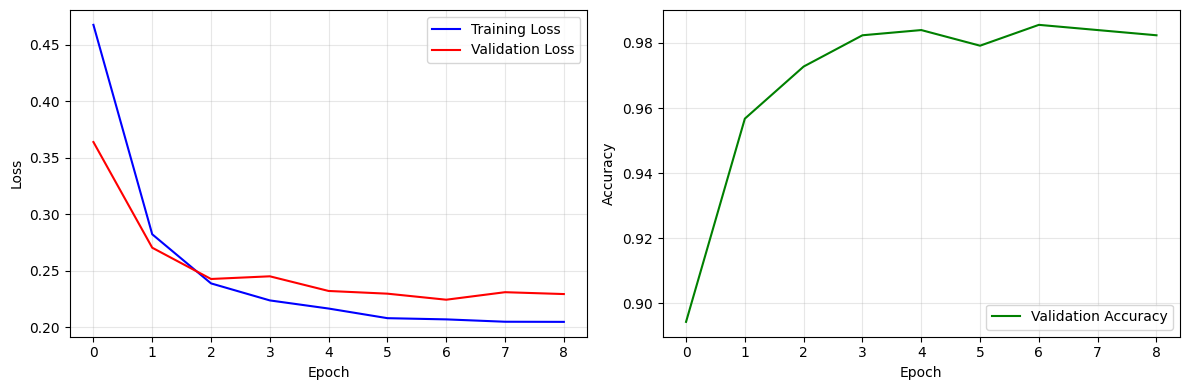


Training complete. Best validation accuracy: 0.9856

---
Evaluating fine-tuned model performance:


Fine-tuned Test:  18%|█▊        | 28/156 [00:52<04:08,  1.94s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4...


Fine-tuned Test:  56%|█████▋    | 88/156 [02:45<02:09,  1.90s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4: [16:44:23] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4] Failed to measure duration/frame-count due to broken metadata.


Fine-tuned Test:  65%|██████▍   | 101/156 [03:11<01:47,  1.96s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4...


Fine-tuned Test:  67%|██████▋   | 105/156 [03:18<01:36,  1.90s/it]

Error loading video D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4...


Fine-tuned Test: 100%|██████████| 156/156 [04:55<00:00,  1.90s/it]


---
Finetuned Performance:
---
Accuracy:  0.9872
Precision: 0.9872
Recall:    0.9872
F1-Score:  0.9872
AUC:       0.9993
---

---
Performance Difference:
---
Accuracy:  0.5128 → 0.9872 (+47.4359%)
F1-Score:  0.4875 → 0.9872 (+49.9727%)
AUC:       0.5035 → 0.9993 (+49.5824%)


In [ ]:
def main():    
    # Initialize config
    config = Config()
    # Prepare data

    train_csv, val_csv, test_csv = prepare_data(config, sample_ratio=0.01)
    
    # Initialize processor
    global PROCESSOR
    PROCESSOR = AutoProcessor.from_pretrained(config.model_name, trust_remote_code=True)
    
    # Evaluate off-the-shelf performance
    print("Off the shelf model performance:")
    
    # Create test dataset and loader
    test_dataset = VideoClassificationDataset(test_csv, PROCESSOR, config.max_frames, config.image_size, is_train=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Load pre-trained model
    pretrained_model = SmolVLMClassifier(config.model_name, config.num_classes)
    pretrained_model = pretrained_model.to(config.device)
    
    # Evaluate
    baseline_metrics = evaluate_model(pretrained_model, test_loader, config, desc="Baseline Test")

    print("---")
    print(f"Accuracy:  {baseline_metrics['accuracy']:.4f}")
    print(f"Precision: {baseline_metrics['precision']:.4f}")
    print(f"Recall:    {baseline_metrics['recall']:.4f}")
    print(f"F1-Score:  {baseline_metrics['f1']:.4f}")
    if baseline_metrics['auc'] is not None:
        print(f"AUC:       {baseline_metrics['auc']:.4f}")
    print("---")
    
    # Clean up pretrained model
    del pretrained_model
    torch.cuda.empty_cache()
    
    # Fine-tune model
    print()
    print("---")
    print("Finetuning:")
    model, best_val_acc = train_model(config, train_csv, val_csv)
    
    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f}")
    

if __name__ == "__main__":
    main()

In [19]:
print("Evaluating fine-tuned model performance:")
global PROCESSOR
if PROCESSOR is None:
    PROCESSOR = AutoProcessor.from_pretrained(config.model_name, trust_remote_code=True)

model = SmolVLMClassifier(config.model_name, config.num_classes)
model = model.to(config.device)
# Load best model
model.load_state_dict(torch.load(f"{config.save_dir}/best_model.pth"))
model = model.to(config.device)

test_dataset = VideoClassificationDataset("./test_sample.csv", PROCESSOR, config.max_frames, config.image_size, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)

finetuned_metrics = evaluate_model(model, test_loader, config, desc="Fine-tuned Test")

print()
print("---")
print("Finetuned Performance:")
print("---")
print(f"Accuracy:  {finetuned_metrics['accuracy']:.4f}")
print(f"Precision: {finetuned_metrics['precision']:.4f}")
print(f"Recall:    {finetuned_metrics['recall']:.4f}")
print(f"F1-Score:  {finetuned_metrics['f1']:.4f}")
if finetuned_metrics['auc'] is not None:
    print(f"AUC:       {finetuned_metrics['auc']:.4f}")
print("---")

Evaluating fine-tuned model performance:


Fine-tuned Test:  18%|█▊        | 28/156 [00:35<02:51,  1.34s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_823.mp4...


Fine-tuned Test:  56%|█████▋    | 88/156 [01:52<01:27,  1.29s/it]

Error loading video D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4: [19:25:00] D:\a\decord\decord\src\video\video_reader.cc:270: [D:/GenVideo/fake/Pika/train_pika/Pika_49630.mp4] Failed to measure duration/frame-count due to broken metadata.


Fine-tuned Test:  65%|██████▍   | 101/156 [02:08<01:11,  1.30s/it]

Error loading video D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4: Error reading D:/GenVideo/fake/DynamicCrafter/train_DynamicCrafter/DynamicCrafter_15287.mp4...


Fine-tuned Test:  67%|██████▋   | 105/156 [02:13<01:04,  1.26s/it]

Error loading video D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4: Error reading D:/GenVideo/real/Kinetics/lm6Jx0zZv54_000019_000029.mp4...


Fine-tuned Test: 100%|██████████| 156/156 [03:19<00:00,  1.28s/it]


---
Finetuned Performance:
---
Accuracy:  0.9872
Precision: 0.9872
Recall:    0.9872
F1-Score:  0.9872
AUC:       0.9993
---


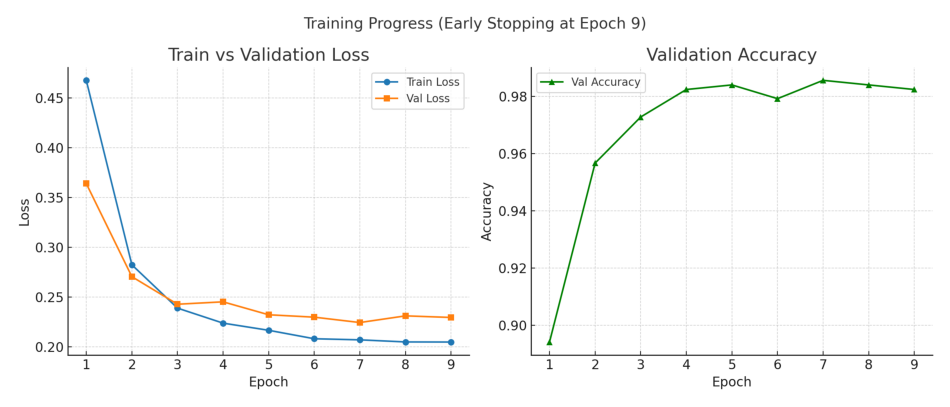

In [22]:
img = plt.imread('./training_curves.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.show()
